In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
from speculator import Photulator
import fsps
import matplotlib.pyplot as plt
import tensorflow as tf

2023-11-23 15:56:28.427299: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-23 15:56:28.427317: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-23 15:56:28.427324: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-23 15:56:28.427609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 15:56:28.427633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
filter_list = fsps.find_filter('lsst') + fsps.find_filter('suprimecam')[1:2]+fsps.find_filter('suprimecam')[3:]
print(filter_list)

['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y', 'suprimecam_g', 'suprimecam_r', 'suprimecam_i', 'suprimecam_z']


In [5]:
#training data
spsparams = np.load("data/data/training_params.npy")[:1000000].astype(np.float32)
photometry = np.load("data/data/training_data.npy")[:1000000].astype(np.float32)
print(spsparams.shape, photometry.shape)

# parameters shift and scale
parameters_shift = np.mean(spsparams, axis=0)
parameters_scale = np.std(spsparams, axis=0)
magnitudes_shift = np.mean(photometry, axis=0)
magnitudes_scale = np.std(photometry, axis=0)

(1000000, 15) (1000000, 10)


In [6]:
#select filters
select = 0
filters = filter_list[select:select+1]
training_theta = tf.convert_to_tensor(spsparams)
training_mag = tf.convert_to_tensor(photometry[:,select:select+1])
print(filter)

# training set up
validation_split = 0.1
lr = [1e-3]#, 1e-4, 1e-5, 1e-5]
batch_size = [1000]#, 10000, 30000, int((1-validation_split) * training_theta.shape[0])]
gradient_accumulation_steps = [1]#, 1, 1, 10]

# early stopping set up
patience = 2

# architecture
n_layers = 4
n_units = 128

#extra params
verbose = True
disable_early_stopping=True

#optimiser
optimiser = tf.keras.optimizers.legacy.Adam()

#running loss
running_loss = []

<class 'filter'>


In [7]:
# architecture
n_hidden = [n_units]*n_layers

# train each band in turn
for f in range(len(filters)):

    if verbose is True:
        print('filter ' + filters[f] + '...')

    # construct the PHOTULATOR model
    photulator = Photulator(n_parameters=training_theta.shape[-1], 
                        filters=[filters[f]], 
                        parameters_shift=parameters_shift, 
                        parameters_scale=parameters_scale, 
                        magnitudes_shift=magnitudes_shift[f], 
                        magnitudes_scale=magnitudes_scale[f], 
                        n_hidden=[128, 128, 128, 128], 
                        restore=False, 
                        restore_filename=None,
                        optimizer=optimiser)

    # train using cooling/heating schedule for lr/batch-size
    for i in range(len(lr)):
        
        if verbose is True:
            print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))

        # set learning rate
        photulator.optimizer.lr = lr[i]

        # split into validation and training sub-sets
        n_validation = int(training_theta.shape[0] * validation_split)
        n_training = training_theta.shape[0] - n_validation
        training_selection = tf.random.shuffle([True] * n_training + [False] * n_validation)

        # create iterable dataset (given batch size)
        train_mag = tf.expand_dims(training_mag[:,f],-1)
        training_data = tf.data.Dataset.from_tensor_slices((training_theta[training_selection], train_mag[training_selection])).shuffle(n_training).batch(batch_size[i])

        # set up training loss
        training_loss = [np.infty]
        validation_loss = [np.infty]
        best_loss = np.infty
        early_stopping_counter = 0

        # loop over epochs
        while early_stopping_counter < patience:

            # loop over batches for a single epoch
            for theta, mag in training_data:

                # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
                if gradient_accumulation_steps[i] == 1:
                    loss = photulator.training_step(theta, mag)
                else:
                    loss = photulator.training_step_with_accumulated_gradients(theta, mag, accumulation_steps=gradient_accumulation_steps[i])

                running_loss.append(loss)
                print(loss)

            # compute total loss and validation loss
            validation_loss.append(photulator.compute_loss(training_theta[~training_selection], train_mag[~training_selection]).numpy())

            # early stopping condition
            if validation_loss[-1] < best_loss:
                best_loss = validation_loss[-1]
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= patience:
                photulator.update_emulator_parameters()
                photulator.save('model_{}x{}'.format(n_layers, n_units) + filters[f])
                if verbose is True:
                    print('Validation loss = ' + str(best_loss))

filter lsst_u...
learning rate = 0.001, batch size = 1000


2023-11-23 15:56:48.354595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(10457.307, shape=(), dtype=float32)
tf.Tensor(9207.322, shape=(), dtype=float32)
tf.Tensor(7897.077, shape=(), dtype=float32)
tf.Tensor(6709.4404, shape=(), dtype=float32)
tf.Tensor(5624.265, shape=(), dtype=float32)
tf.Tensor(4585.31, shape=(), dtype=float32)
tf.Tensor(3459.1455, shape=(), dtype=float32)
tf.Tensor(2560.6836, shape=(), dtype=float32)
tf.Tensor(1954.1848, shape=(), dtype=float32)
tf.Tensor(1605.488, shape=(), dtype=float32)
tf.Tensor(1811.1283, shape=(), dtype=float32)
tf.Tensor(2176.9949, shape=(), dtype=float32)
tf.Tensor(2408.4585, shape=(), dtype=float32)
tf.Tensor(2513.0564, shape=(), dtype=float32)
tf.Tensor(2503.8938, shape=(), dtype=float32)
tf.Tensor(2340.9531, shape=(), dtype=float32)
tf.Tensor(2145.8342, shape=(), dtype=float32)
tf.Tensor(1830.823, shape=(), dtype=float32)
tf.Tensor(1539.4662, shape=(), dtype=float32)
tf.Tensor(1306.7955, shape=(), dtype=float32)
tf.Tensor(1151.9912, shape=(), dtype=float32)
tf.Tensor(1276.1031, shape=(), dtype=floa

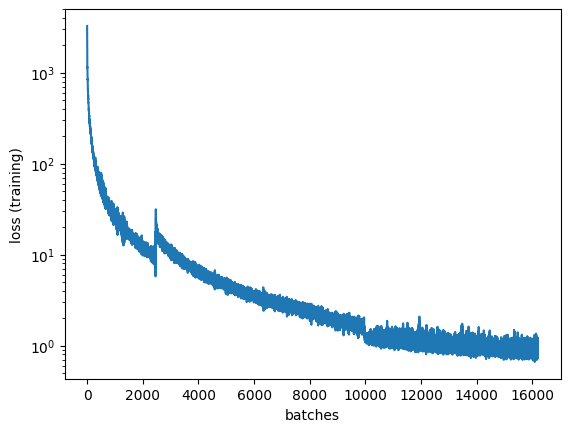

In [7]:
plt.plot(running_loss)
plt.ylabel('loss (training)')
plt.xlabel('batches')
plt.yscale("log")

Text(0.5, 0, 'epoch')

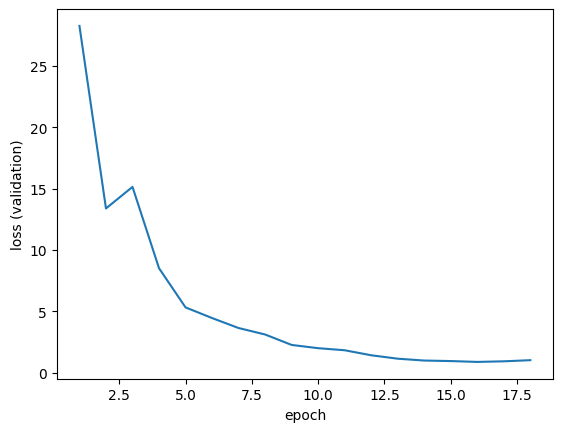

In [8]:
plt.plot(validation_loss)
plt.ylabel('loss (validation)')
plt.xlabel('epoch')